파이썬 입문 실습용 파일을 종합하여 24.11 외대 대학원 특강용으로 재구성.

마이닝에 적합한 내용으로 구성함.

작성일: 24년 10-11월


**순서**

파이썬 사용 환경 만들기

텍스트 파일 준비하기(txt 또는 csv)

전처리하기

# 라이브러리, 모델, 토크나이저 로드

In [1]:
pip install transformers torch matplotlib

In [2]:
import torch
print(torch.cuda.is_available())  # GPU가 사용 가능한지 확인

True


In [4]:
import numpy as np
import pandas as pd
import urllib.request
from tqdm import tqdm
import torch
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from transformers import BertTokenizer, BertForMaskedLM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
from konlpy.tag import Okt

In [5]:
# 독일어 BERT 모델 및 토크나이저 로드
# bert-base-german-cased 로 하거나 아니면 dbmdz/bert-base-german-cased
model_name = "dbmdz/bert-base-german-cased"
tokenizer = BertTokenizer.from_pretrained(model_name) #모델명 바뀌면 위에서 재정의만.
model = BertForMaskedLM.from_pretrained(model_name)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at dbmdz/bert-base-german-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

# 코퍼스 로드 (또는 직접 입력)

In [ ]:
#코랩인 경우

from google.colab import drive
drive.mount('/content/drive')

In [8]:
file_path = "/content/drive/My Drive/My Journals/corpus_choi/corpus_news/news_de.txt"

with open(file_path, 'r', encoding='utf-8') as file:
    text = file.read()
    print(text)


Präsident Yoon Suk Yeol nahm am 13. Juni am “Treffen mit der innovativen nächsten Generationen” im U-Enter, einem Zentrum zur Existenzgründungsförderung, in Taschkent, Hauptstadt von Kasachstan, teil. Dabei versprach er die aktive Unterstützung der koreanischen Regierung für die Verstärkung von Kooperation und Austausch zwischen den Humanressourcen im Bereich Technologien und Start-ups aus den beiden Ländern und die Heranziehung der Fachkräfte. Anschließend betonte er, „Im vom digitalen Wandel eingeprägten Zeitalter werden die Start-ups mit Deep Tech wie KI und Blockkette das wirtschaftliche Wachstum anführen.” Zugleich erwähnte er das “Youth Innovation Silk Road Reboot Program” der KOICA (Korea International Cooperation Agency). Es zielt darauf, durch die öffentliche Entwicklungszusammenarbeit (ODA) die Fachkräfte mit unternehmerischen Fähigkeiten herauszubilden und die Industrie-maßgeschneiderten Entwicklungsprogramme anzubieten. Die Vertreter der Start-ups aus beiden Länder, jugendl

# 전처리

## 독일어 전처리 (spacy)

In [11]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

model_name = "dbmdz/bert-base-german-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

nlp = pipeline("ner", model=model, tokenizer=tokenizer, grouped_entities=True)


beispiel = "Das ist ein Beispieltext auf Deutsch."

tokens = tokenizer.tokenize(text)
tokens_with_tags = nlp(text)

print(tokens)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/token_classification.py:168: UserWarning: `grouped_entities` is deprecated and will be removed in ve

['Präsident', 'Yo', '##on', 'Su', '##k', 'Ye', '##ol', 'nahm', 'am', '13', '.', 'Juni', 'am', '“', 'Treffen', 'mit', 'der', 'innovativen', 'nächsten', 'Generationen', '”', 'im', 'U', '-', 'Enter', ',', 'einem', 'Zentrum', 'zur', 'Existenz', '##gründung', '##sf', '##örderung', ',', 'in', 'Ta', '##schke', '##nt', ',', 'Hauptstadt', 'von', 'Kasachst', '##an', ',', 'teil', '.', 'Dabei', 'versprach', 'er', 'die', 'aktive', 'Unterstützung', 'der', 'kore', '##anischen', 'Regierung', 'für', 'die', 'Verstärkung', 'von', 'Kooperation', 'und', 'Austausch', 'zwischen', 'den', 'Human', '##ressourcen', 'im', 'Bereich', 'Technologien', 'und', 'Start', '-', 'up', '##s', 'aus', 'den', 'beiden', 'Ländern', 'und', 'die', 'Her', '##anz', '##ieh', '##ung', 'der', 'Fachkräfte', '.', 'Anschließend', 'betonte', 'er', ',', '„', 'Im', 'vom', 'digitalen', 'Wandel', 'einge', '##prä', '##gten', 'Zeitalter', 'werden', 'die', 'Start', '-', 'up', '##s', 'mit', 'De', '##ep', 'Tech', 'wie', 'K', '##I', 'und', 'Block', 

In [24]:
# 텍스트 전처리
    # text = text.lower() 소문자변환 필요시
    # text.replace(',', '') 는 구나 절이 있을수도 있으므로 하지 않음. 콜론은 상황에 맞게 설정.
def preprocess_text(text):
    text = text.replace('.', '').replace('!', '').replace('?', '').replace('"', '').replace("'", '').replace("Yoon", "")
    return text

    # 텍스트를 단어 단위로 분할(필요시)
def split_text_into_words(text):
    words = text.split()
    return words

## 한국어 전처리 (Konlpy)

In [12]:
pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 37.7 MB/s eta 0:00:00


In [13]:
from konlpy.tag import Kkma
import nltk
from nltk.tag import pos_tag
kkma = Kkma()
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

print(kkma.sentences(u'네, 안녕하세요. 반갑습니다.'))

[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


['네, 안녕하세요.', '반갑습니다.']


빈도 수, 워드 클라우드

In [14]:
pip install konlpy wordcloud matplotlib numpy

In [15]:
import numpy as np
from konlpy.tag import Okt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [25]:
# nltk 토큰화
nltk.download('punkt')
tokens = nltk.word_tokenize(text, language='german')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [26]:
# 가장 빈번한 단어 100개 추출
frequency = Counter(tokens)
most_common_100 = frequency.most_common(100)
print("Most Common 100 Words:", most_common_100)


Most Common 100 Words: [(',', 399), ('.', 344), ('die', 311), ('und', 300), ('der', 283), ('für', 161), ('in', 146), ('von', 133), ('den', 110), ('“', 106), ('mit', 99), ('im', 96), ('Korea', 83), ('auf', 78), ('das', 73), ('%', 72), ('zu', 67), ('des', 57), ('Die', 55), ('dem', 55), ('am', 49), ('dass', 48), ('”', 45), ('wird', 45), ('zum', 43), ('wurde', 42), ('sich', 41), ('(', 39), (')', 39), ('wie', 38), ('werden', 36), ('Jahr', 36), ('zwischen', 35), ('„', 35), ('Seoul', 34), ('vom', 33), (':', 33), ('um', 32), ('koreanischen', 30), ('ein', 30), ('aus', 29), ('über', 29), ('als', 29), ('Das', 27), ('Mai', 27), ('Yoon', 25), ('ihre', 25), ('nach', 25), ('bis', 25), ('koreanische', 24), ('ist', 24), ('Dollar', 24), ('eine', 23), ('Platz', 23), ('sie', 22), ('an', 21), ('Der', 21), ('letzten', 21), ('Präsident', 20), ('zur', 20), ('Afrika', 20), ('Milliarden', 19), ('Juni', 18), ('bei', 18), ('Unternehmen', 18), ('Entwicklung', 18), ('auch', 18), ('sagte', 18), ('Ausländer', 18), ('

In [32]:
import nltk
from nltk.corpus import stopwords

# 독일어 불용어 다운로드 (처음 사용할 경우)
nltk.download('stopwords')

# 독일어 불용어 리스트 로드
german_stopwords = set(stopwords.words('german'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:

# 토큰화 및 불용어 제거
filtered_words = [word for word in text.split() if word.lower() not in german_stopwords]


In [36]:

# 워드클라우드 생성
# most_common_100 데이터로 워드클라우드 만들기
word_freq_dict = dict(most_common_100)  # 빈도수를 dictionary 형태로 변환
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq_dict)

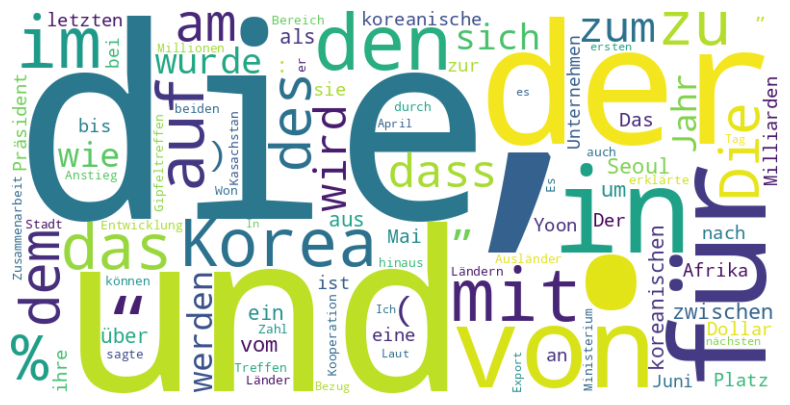

In [37]:

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#한국어 텍스트 불러오기

In [ ]:
text_kr =